In [4]:
import sys
sys.path.append("../data_analysis_and_preparation")
from prepare_human_feedback import get_data_from_excel

In [16]:
def transform_df(df):

    if "usefullness" in df.columns:  #typo...
        df.rename(columns={"usefullness":"usefulness"}, inplace=True)

    # include the correctness in the fact-checking
    df.loc[df["correctness"]!= "Recherche nötig", "fact_check"] = df.loc[df["correctness"]!= "Recherche nötig", "correctness"]
    for i, row in df.iterrows():
        try:
            df.loc[i,] = translate_row(row)
        except KeyError:
            pass
    
    return df

def translate_row(row):
    translator = {
        "style": {
            "Der Text ist unverständlich": "incomprehensible",
            "Der Text ist verständlich, aber stilistisch unpassend": "inadequate",
            "Der Text ist einer wissenschaftlichen Edition angemessen": "adequate"

        },
        "usefulness": {
            "Die Fussnote ist irrelevant": "irrelevant",
            "Die Fussnote ist teilweise relevant": "partially relevant",
            "Die Fussnote ist relevant": "relevant",
        },
        "correctness":{
            "Enthält Fehlinformationen": "incorrect",
            "Keine Fehlinformationen": "correct",
            "Keine Einschätzung möglich": "subjective",
            "Recherche nötig": "research required"
        }
    }
    if row.style:
        row.style = translator["style"][row.style.strip()]
    if row.usefulness:
        row.usefulness = translator["usefulness"][row.usefulness.strip()]
    if row.fact_check:
        row.fact_check = translator["correctness"][row.fact_check.strip()]
    if row.correctness:
        row.correctness = translator["correctness"][row.correctness.strip()]
    
    # write "Human" instead of text_footnote
    if row.model == "text_footnote":
        row.model = "Human"
    
    return row
    

In [9]:
"bla bla ".strip()

'bla bla'

In [6]:
import matplotlib.pyplot as plt
def plot_human_eval(df):
    # Group and calculate counts for each category
    categories = ['style', 'usefulness', "correctness", 'fact_check']
    # grouped_data = {cat: df.groupby(['model', cat]).size().unstack(fill_value=0) for cat in categories}
    grouped_data = {
    cat: df.groupby(['model', cat]).size().unstack(fill_value=0).apply(lambda x: (x / x.sum()) * 100, axis=1)
    for cat in categories
    }

    category_colors = {
    'adequate': 'blue',
    'inadequate': 'green',
    'incomprehensible': 'red',
    'irrelevant': 'blue',  # Example mappings,
    "partially relevant": "green",
    "relevant": "red",
    "correct": "blue",
    "incorrect": "green",
    "subjective": "red",
    "research required": "orange"
    }
    

    # Set up a 2x2 grid for the subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()  # Flatten the 2x2 array to easily iterate

    # Colors for the bar plots
    colors = ['blue', 'green', 'red', 'orange']

    # Loop through each category and corresponding axis
    for idx, (cat, ax) in enumerate(zip(categories, axes)):
        grouped_data[cat].plot(
            kind='bar',
            ax=ax,
            color=category_colors,
            edgecolor='black',
            legend=True
        )
            # Rotate tick descriptions horizontally
        ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
        ax.set_title(cat.replace("_", " ").title())
        ax.set_xlabel('')
        ax.set_ylabel('Percentage')
        ax.grid(True, axis="y", linestyle='--', alpha=0.6)
        # Create a custom legend for each subplot
        legend_handles, legend_labels = ax.get_legend_handles_labels()
        ax.legend(
            handles=legend_handles,
            labels=legend_labels,
            loc='lower center',
            bbox_to_anchor=(0.5, -0.15),  # Adjust position below each chart
            ncol=len(legend_handles),  # Arrange in a single row
        )


    # Adjust layout and show the plot
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.25) 
    return fig



In [14]:
luca_df = get_data_from_excel("human_eval/final_evaluation_form_LB.xlsx", "human_eval/final_evaluation_model_key.xlsx")
transform_df(luca_df)
luca_df

,letter_id,n_footnote,model,text_footnote,style,usefulness,correctness,fact_check,commentary
0,11755,104,llama-70B,"Vgl. 1Kor 7, 25; 2Kor 8, 10; 1Tim 5, 14.",adequate,relevant,research required,incorrect,None
1,11755,104,gpt-4o,"Der Ausdruck ""ad Kalendas Graecas"" stammt aus ...",inadequate,irrelevant,subjective,subjective,None
2,11755,104,Human,"Vgl. 1Kor 7, 25.",adequate,relevant,research required,correct,None
3,11755,104,llama-8B,"4, 1.",incomprehensible,None,None,None,None
4,10052,38,llama-70B,"Vgl. 1 Kor 7, 1ff.",inadequate,relevant,incorrect,incorrect,Die erste Fussnote enthält insofern Fehlinform...
...,...,...,...,...,...,...,...,...,...
155,11537,34,llama-8B,Philippa von Hessen.,adequate,relevant,incorrect,incorrect,None
156,11537,20,llama-8B,Rodolphus Ryff.,adequate,relevant,incorrect,incorrect,None
157,11537,20,gpt-4o,"Die Erwähnung einer ""altera"" bezieht sich verm...",inadequate,relevant,subjective,subjective,None
158,11537,20,Human,Landgräfin Christine von Hessen.,adequate,relevant,subjective,subjective,None


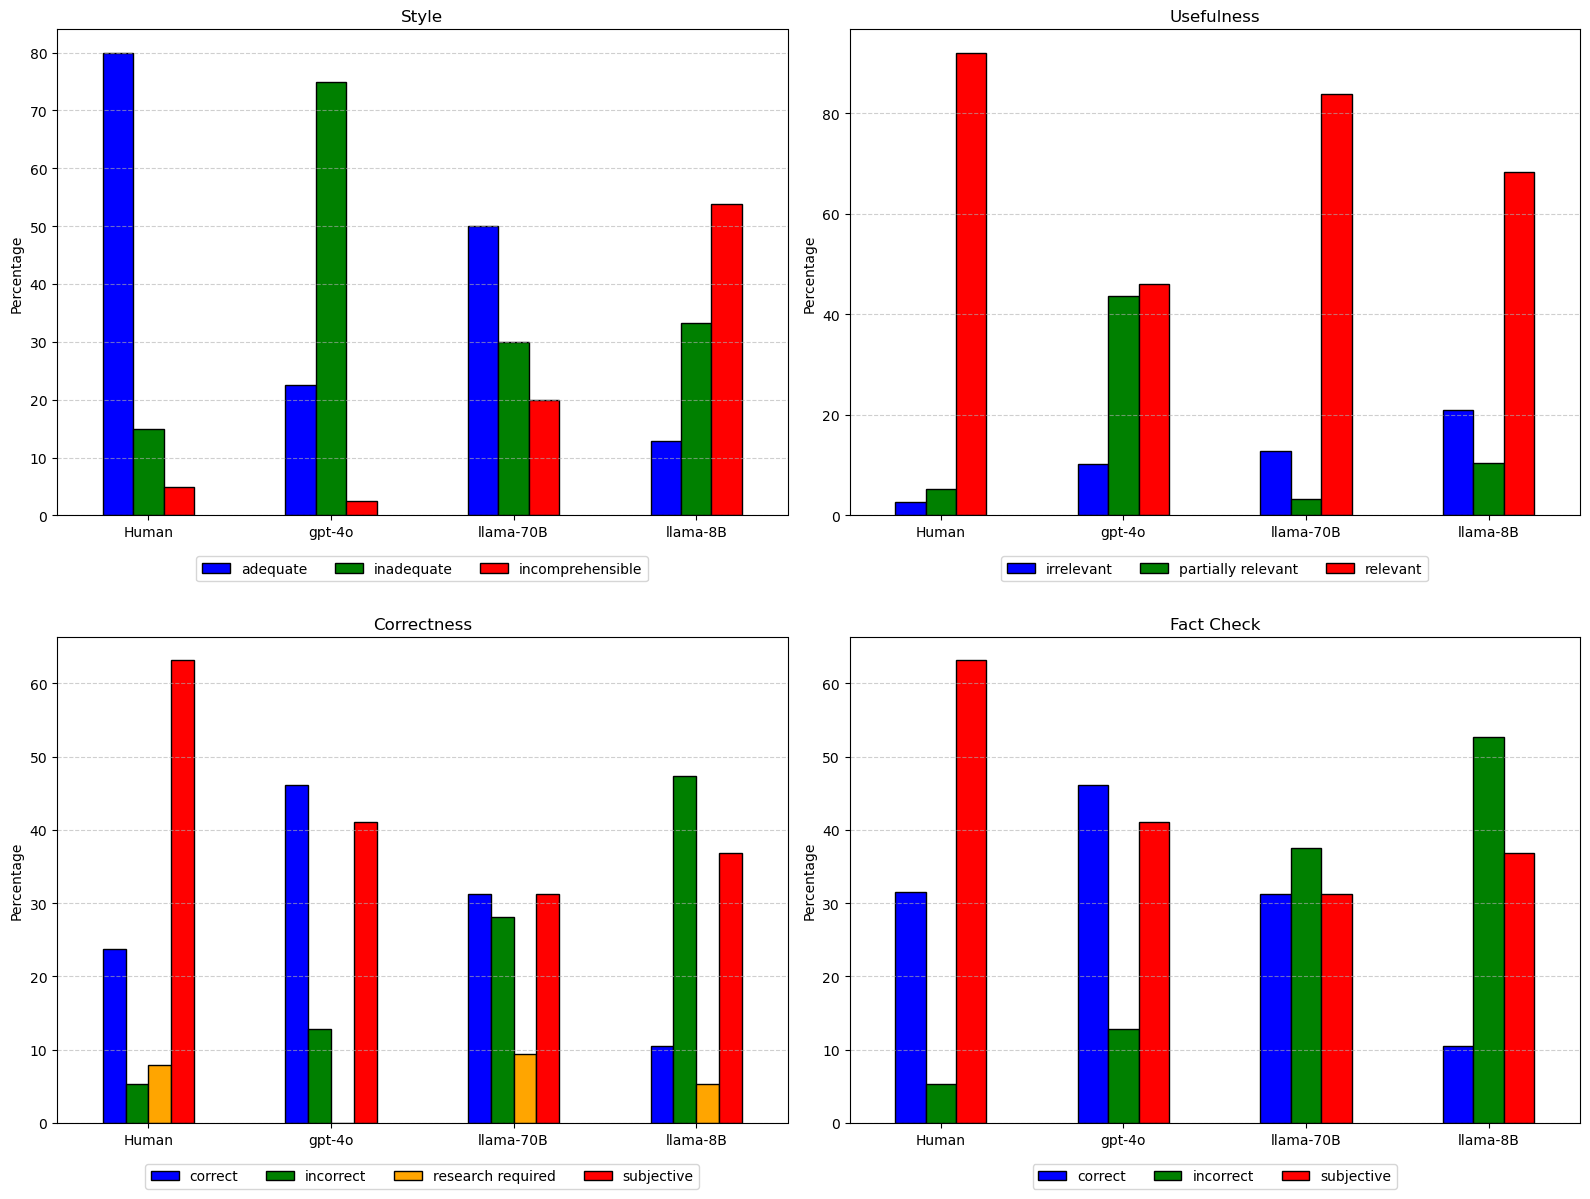

In [ ]:
import os

fig = plot_human_eval(luca_df)
if False:
    plot_folder = os.path.abspath(r"/mnt/c/Users/nik_b/Documents/UZH/CL/Master_thesis_text/master-thesis/images/plots")
    # plot_folder = "../plots"
    plot_name = "humanEval-LB.pdf"
    plt.savefig(os.path.join(plot_folder, plot_name), dpi=300, bbox_inches='tight',format='pdf')

In [18]:
def unique_list(l):
    """make unique, preserving order
    returns list with unique items"""
    unique_l = []
    for i, item in enumerate(l):
        if i == 0:
            unique_l.append(item)
        elif item != l[i-1]:
            unique_l.append(l)
    return unique_l


def human_footnote_ranking(df):
    # For each footnote and category calculate a ranking
    unique_letter_ids = unique_list(df["letter_id"])
    unique_n_footnotes = unique_list(df["n_footnote"])
    models = ["llama-70B", "gpt-4o", "Human", "llama-8B"]

    style_points = {
        "adequate": 2,
        "inadequate": 1,
        "incomprehensible":0
    }
    usefulness_points = {
        "relevant": 2,
        "partially relevant": 1,
        "irrelevant": 0
    }
    
    results = {}
    for letter_id, n_footnote in zip(unique_letter_ids, unique_n_footnotes):
        footnote_df = df.loc[(df["letter_id"]==letter_id)&(df["n_footnote"]==n_footnote)]
        model_points = {}
        for model in models:
            if footnote_df[footnote_df["model"]]["style"]:  # checking if no none...
                style = style_points[footnote_df[footnote_df["model"]]["style"]]
            else: style = 0
            if footnote_df[footnote_df["model"]]["usefulness"]:
                usefulness = usefulness_points[footnote_df[footnote_df["model"]]["usefulness"]]
            else: usefulness = 0
            model_points[model] = style+usefulness
        

        return footnote_df
        break
human_footnote_ranking(luca_df)

KeyError: "None of [Index(['llama-70B', 'gpt-4o', 'Human', 'llama-8B'], dtype='object')] are in the [columns]"

In [4]:
transform_df(luca_df)

letter_id                                                    11755
n_footnote                                                     104
model                                                       gpt-4o
text_footnote    Der Ausdruck "ad Kalendas Graecas" stammt aus ...
style            Der Text ist verständlich, aber stilistisch un...
usefullness                           Die Fussnote ist irrelevant 
correctness                             Keine Einschätzung möglich
fact_check                              Keine Einschätzung möglich
commentary                                                    None
Name: 1, dtype: object


,letter_id,n_footnote,model,text_footnote,style,usefullness,correctness,fact_check,commentary
0,11755,104,llama-70B,"Vgl. 1Kor 7, 25; 2Kor 8, 10; 1Tim 5, 14.",adequate,relevant,research required,incorrect,None
1,11755,104,gpt-4o,"Der Ausdruck ""ad Kalendas Graecas"" stammt aus ...",inadequate,irrelevant,subjective,subjective,None
2,11755,104,text_footnote,"Vgl. 1Kor 7, 25.",adequate,relevant,research required,correct,None
3,11755,104,llama-8B,"4, 1.",incomprehensible,None,None,None,None
4,10052,38,llama-70B,"Vgl. 1 Kor 7, 1ff.",inadequate,relevant,incorrect,incorrect,Die erste Fussnote enthält insofern Fehlinform...
...,...,...,...,...,...,...,...,...,...
155,11537,34,llama-8B,Philippa von Hessen.,adequate,relevant,incorrect,incorrect,None
156,11537,20,llama-8B,Rodolphus Ryff.,adequate,relevant,incorrect,incorrect,None
157,11537,20,gpt-4o,"Die Erwähnung einer ""altera"" bezieht sich verm...",inadequate,relevant,subjective,subjective,None
158,11537,20,text_footnote,Landgräfin Christine von Hessen.,adequate,relevant,subjective,subjective,None


/home/niko/anaconda3/lib/python3.11/site-packages/openpyxl/reader/excel.py:228: UserWarning: Data Validation extension is not supported and will be removed
  ws_parser.bind_all()


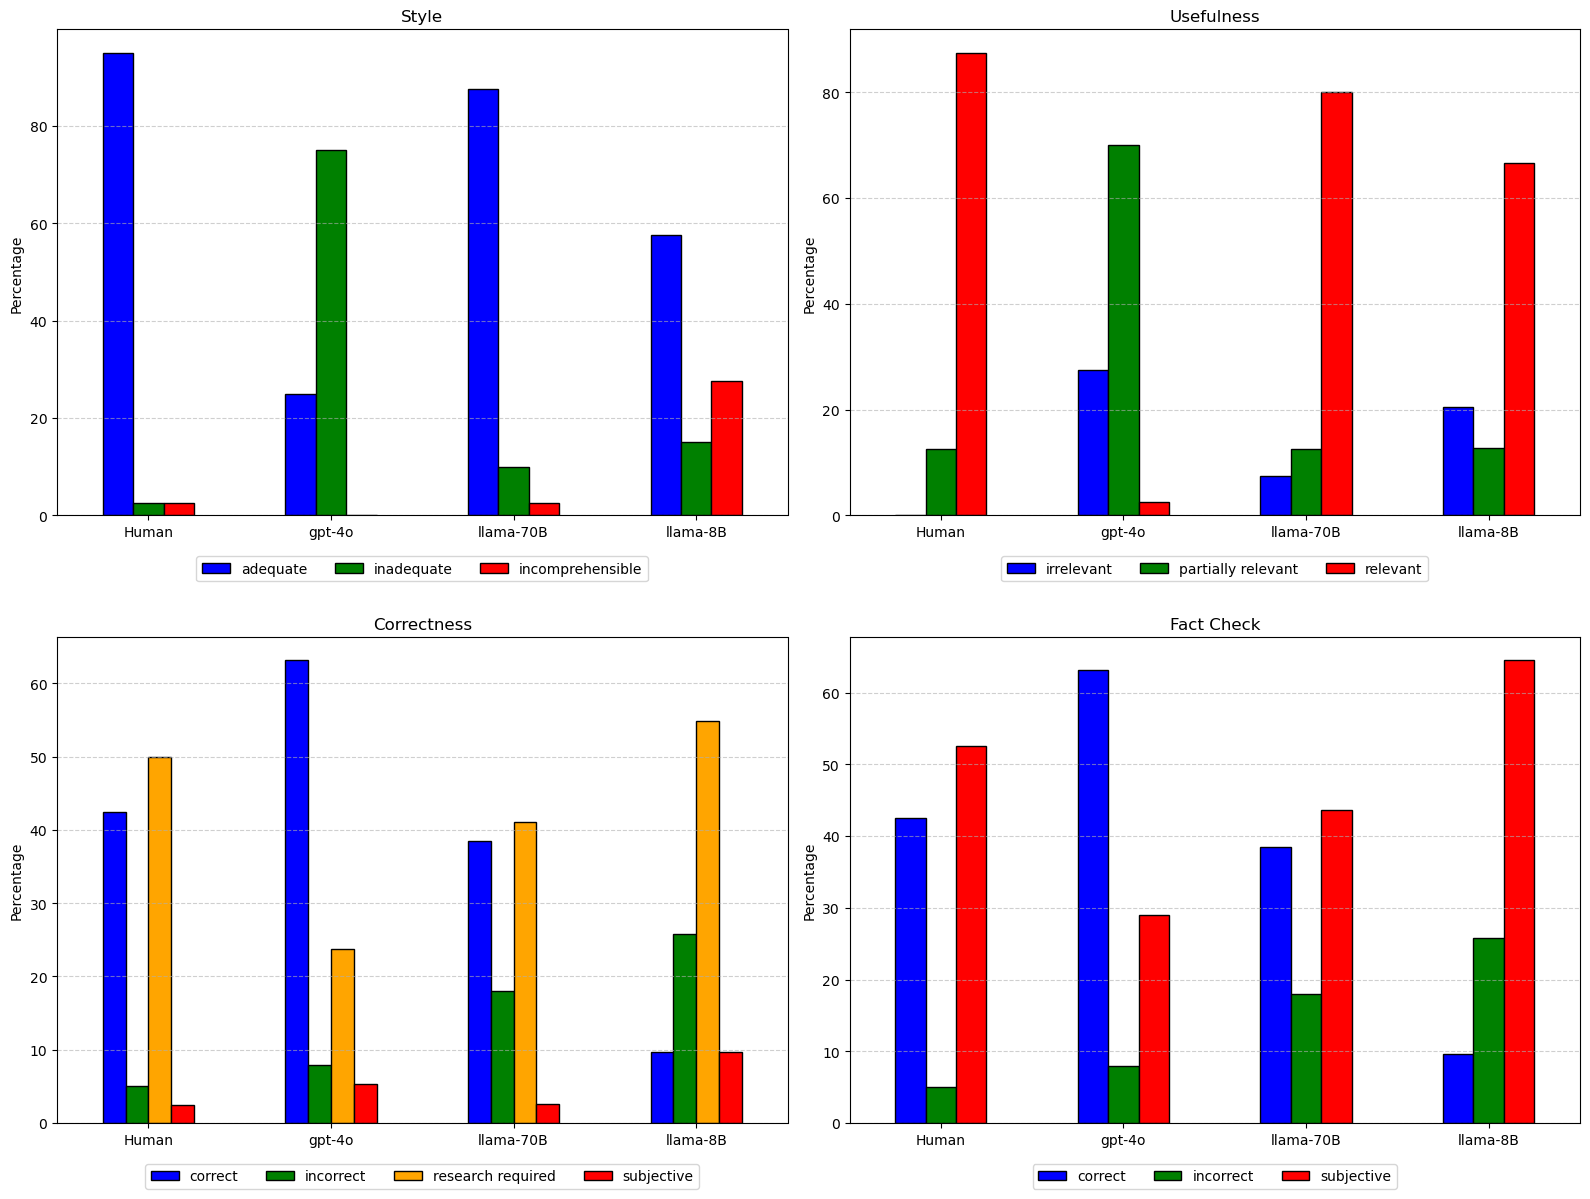

In [20]:
tj_df = get_data_from_excel("human_eval/final_evaluation_form_TJ.xlsx", "human_eval/final_evaluation_model_key.xlsx")
transform_df(tj_df)
fig = plot_human_eval(tj_df)

/home/niko/anaconda3/lib/python3.11/site-packages/openpyxl/reader/excel.py:228: UserWarning: Data Validation extension is not supported and will be removed
  ws_parser.bind_all()


KeyError: 'Die Fussnote ist irrelevant '

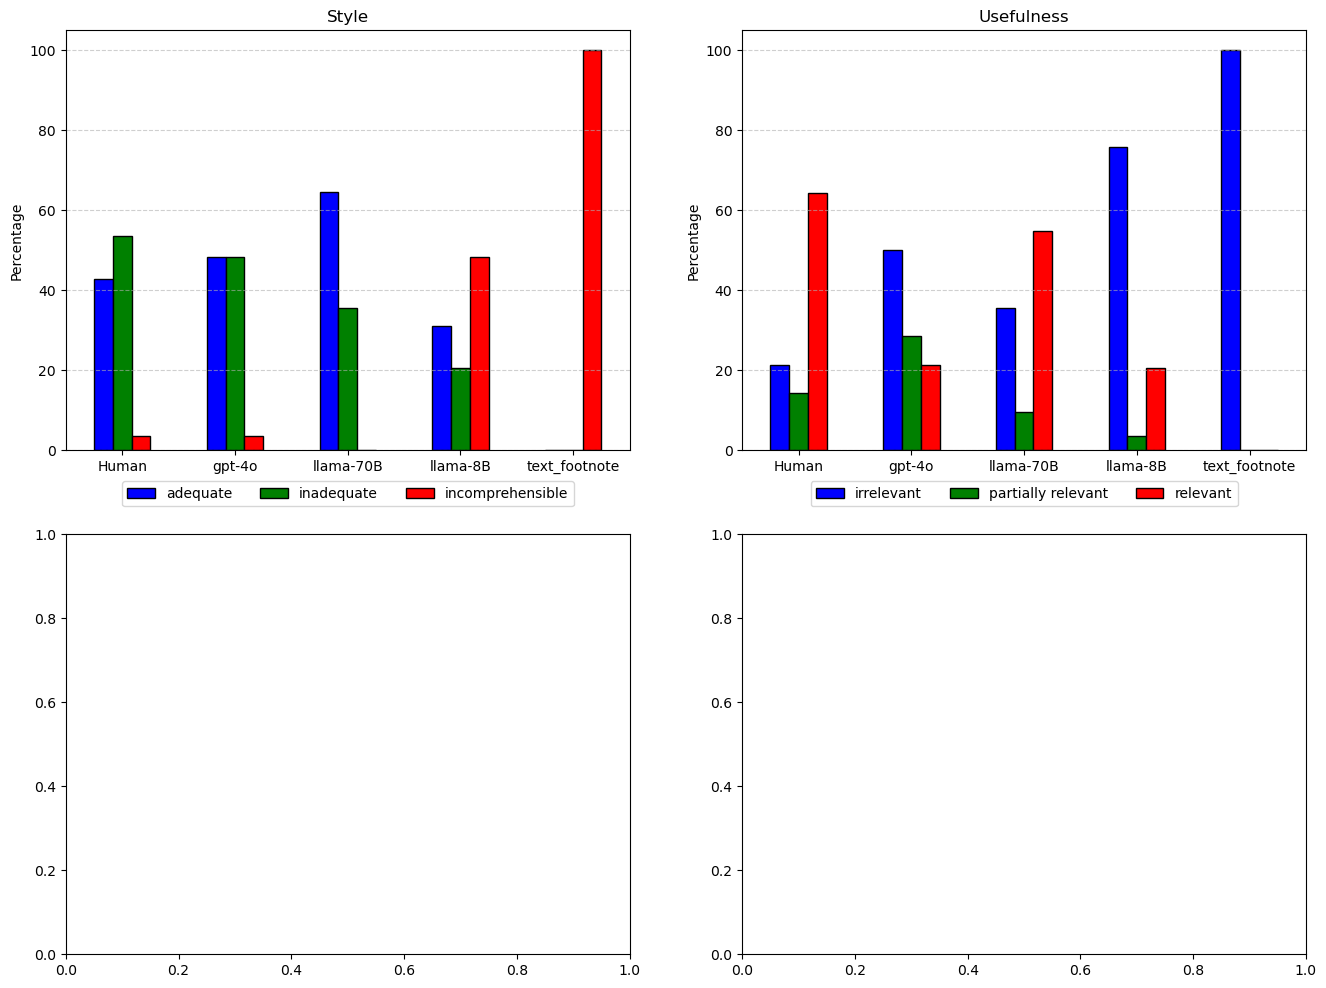

In [21]:
pn_df = get_data_from_excel("human_eval/final_evaluation_form_PN.xlsx", "human_eval/final_evaluation_model_key.xlsx")
transform_df(pn_df)
fig = plot_human_eval(pn_df)